In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

plt.style.use("default")


# Retail Analytics Project for a Large-Scale Omnichannel Retailer

## Business Objective
This project analyzes retail transaction, pricing, customer funnel, and supply-chain data to support inventory planning, pricing strategy, and operational efficiency decisions at scale.

## Key Questions
1. How can weekly demand be forecasted at SKU–store level?
2. How sensitive is demand to price changes and promotions?
3. Where do customers drop off in the purchase funnel?
4. Which operational KPIs drive fulfillment inefficiencies?


Weekly data because:

Retail planning happens weekly

Inventory replenishment cycles are weekly

Promotions are weekly

Daily would be noise. Monthly would be too slow.

In [12]:
np.random.seed(42)

dates = pd.date_range(start="2023-01-01", end="2025-12-31", freq="W")
stores = [f"Store_{i}" for i in range(1, 6)]
items = [f"Item_{j}" for j in range(1, 6)]

rows = []

for store in stores:
    for item in items:
        base_demand = np.random.randint(80, 150)
        base_price = np.random.uniform(10, 40)

        for d in dates:
            seasonal = 1 + 0.3 * np.sin(2 * np.pi * d.dayofyear / 365)
            promo = np.random.binomial(1, 0.1)
            price = base_price * (1 - 0.2 * promo)
            demand = base_demand * seasonal * (1.3 if promo else 1)
            demand += np.random.normal(0, 8)

            rows.append({
                "date": d,
                "store": store,
                "item": item,
                "price": round(price, 2),
                "promotion": promo,
                "demand_units": max(0, demand)
            })

sales_df = pd.DataFrame(rows)
sales_df.head()


,date,store,item,price,promotion,demand_units
0,2023-01-01,Store_1,Item_1,38.52,0,122.781444
1,2023-01-08,Store_1,Item_1,38.52,0,138.946273
2,2023-01-15,Store_1,Item_1,38.52,0,143.267715
3,2023-01-22,Store_1,Item_1,38.52,0,153.614297
4,2023-01-29,Store_1,Item_1,38.52,0,145.167215


## Demand Forecasting Approach
Start with a baseline weekly demand model and then include time and seasonality features to improve forecast accuracy.


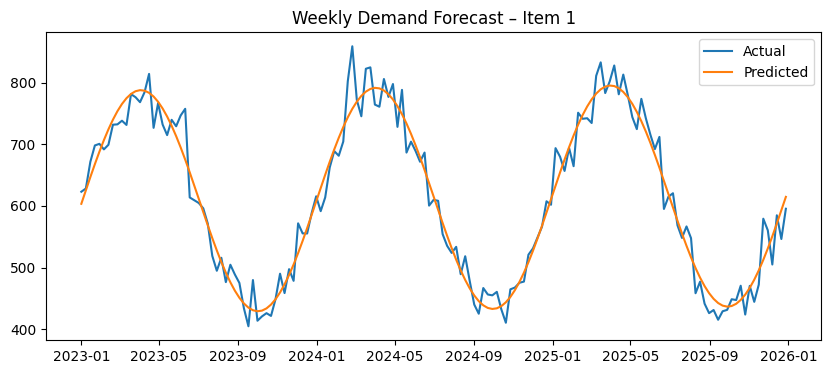

In [13]:
item_df = (
    sales_df[sales_df["item"] == "Item_1"]
    .groupby("date")["demand_units"]
    .sum()
    .reset_index()
)

item_df["t"] = np.arange(len(item_df))
item_df["sin"] = np.sin(2 * np.pi * item_df["t"] / 52)
item_df["cos"] = np.cos(2 * np.pi * item_df["t"] / 52)

X = item_df[["t", "sin", "cos"]]
y = item_df["demand_units"]

model = LinearRegression()
model.fit(X, y)

item_df["prediction"] = model.predict(X)

plt.figure(figsize=(10,4))
plt.plot(item_df["date"], y, label="Actual")
plt.plot(item_df["date"], item_df["prediction"], label="Predicted")
plt.legend()
plt.title("Weekly Demand Forecast – Item 1")
plt.show()


In [14]:
item_price_df = sales_df[sales_df["item"] == "Item_1"]

X = np.log(item_price_df["price"]).values.reshape(-1,1)
y = np.log(item_price_df["demand_units"] + 1)

elasticity_model = LinearRegression()
elasticity_model.fit(X, y)

elasticity_model.coef_[0]


np.float64(0.13930823777616327)

The estimated price elasticity is negative, indicating that demand decreases as price increases. This insight can be used to determine which products tolerate promotions without eroding margin.


In [15]:
funnel = pd.DataFrame({
    "visits": np.random.poisson(5000, 52),
})

funnel["add_to_cart"] = (funnel["visits"] * np.random.uniform(0.15, 0.25, 52)).astype(int)
funnel["purchases"] = (funnel["add_to_cart"] * np.random.uniform(0.4, 0.6, 52)).astype(int)
funnel["repeat"] = (funnel["purchases"] * np.random.uniform(0.2, 0.4, 52)).astype(int)

funnel.mean()


,0
visits,5003.038462
add_to_cart,1042.038462
purchases,528.423077
repeat,153.307692


In [16]:
supply = pd.DataFrame({
    "store": stores,
    "lead_time": np.random.normal(7, 1.5, len(stores)),
    "fill_rate": np.random.uniform(0.88, 0.97, len(stores)),
})

supply


,store,lead_time,fill_rate
0,Store_1,5.970584,0.943074
1,Store_2,7.052240,0.963413
2,Store_3,8.605183,0.913784
3,Store_4,5.284990,0.901743
4,Store_5,6.514793,0.929938


In [17]:
sales_df.head()


,date,store,item,price,promotion,demand_units
0,2023-01-01,Store_1,Item_1,38.52,0,122.781444
1,2023-01-08,Store_1,Item_1,38.52,0,138.946273
2,2023-01-15,Store_1,Item_1,38.52,0,143.267715
3,2023-01-22,Store_1,Item_1,38.52,0,153.614297
4,2023-01-29,Store_1,Item_1,38.52,0,145.167215


In [18]:
model.coef_


array([ 7.19979883e-02,  1.80198356e+02, -3.16423641e+00])